## Task - 3 Fast Gradient Sign Method for Adversarial Attacks
Lets play a game of adversaries. Convolutional Neural Networks (CNNs) have achieved remarkable success in image classification tasks, from medical imaging to self-driving cars. However, CNNs are not invincible. Tiny, carefully crafted perturbations that are often imperceptible to the human eye, can cause a model to make confident but wrong predictions. This phenomenon is known as an adversarial attack.

One of the simplest and most famous attacks is the Fast Gradient Sign Method (FGSM), introduced by Goodfellow et al. (2015).

In this task we will use the same technique to check if the CNN classifier you developed in task-1 is vulnerable to adversarial attacks. You will need to use FGSM to create adversarial examples for the test dataset and check if the model is still able to make correct predictions.

For submission you will require to submit the accuracy score on the adversarial examples with at least 3 different epsilon values and display the adversarial images for each epsilon value.

## Loading DS + Model

In [2]:
!pip install captum --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 125.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


### Import Libraries
Import PyTorch and necessary libraries for adversarial attacks.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from datasets import load_dataset
from captum.attr import LayerGradCam, LayerAttribution, Occlusion
import matplotlib.cm as cm
import os
import math

### Load and Prepare Dataset
Load the cats vs dogs dataset and create test split.


In [4]:
ds = load_dataset("pantelism/cats-vs-dogs")

train_test_split = ds['train'].train_test_split(test_size=0.2, seed=42)
test_ds = train_test_split['test']

class CustomDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['label']

        if self.transform:
            image = self.transform(image)

        return image, label

test_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_dataset = CustomDataset(test_ds, transform=test_tf)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dogs-vs-cats-subset.zip:   0%|          | 0.00/90.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4000 [00:00<?, ? examples/s]

### Define and Load Model
Define the SimpleCNN architecture and load pre-trained weights.


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "cnn_weights.pth"

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return F.relu(out + x)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2, p_drop=0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            ResidualBlock(128),
            nn.Conv2d(128, 256, 3, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2),
            ResidualBlock(256),
            nn.Conv2d(256, 512, 3, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d(2),
            ResidualBlock(512),
            nn.Conv2d(512, 512, 3, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p_drop)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

model = SimpleCNN()
obj = torch.load(MODEL_PATH, map_location=device)
if isinstance(obj, dict):
    model.load_state_dict(obj, strict=False)
else:
    model = obj
model.to(device).eval()

print("model loaded")


model loaded


## FGSM Evaluation

### FGSM Attack Implementation
Define FGSM attack function and helper utilities for generating adversarial examples.


In [6]:
device = next(model.parameters()).device
model.eval()

epsilons = [0.005, 0.01, 0.03]
n_display = 5
mean = torch.tensor([0.485,0.456,0.406], device=device).view(1,3,1,1)
std  = torch.tensor([0.229,0.224,0.225], device=device).view(1,3,1,1)

def denorm_to_uint8(x_tensor):
    x = x_tensor.detach().cpu() * std.cpu() + mean.cpu()
    x = torch.clamp(x, 0.0, 1.0)
    arr = (x[0].permute(1,2,0).numpy() * 255).astype(np.uint8)
    return arr

def batch_denorm_to_uint8(x_tensor):
    x = x_tensor.detach().cpu() * std.cpu() + mean.cpu()
    x = torch.clamp(x, 0.0, 1.0)
    arr = (x.permute(0,2,3,1).numpy() * 255).astype(np.uint8)
    return arr

def fgsm_normalized(model, x, y, epsilon):
    x = x.clone().to(device)
    x.requires_grad = True
    logits = model(x)
    loss = F.cross_entropy(logits, y.to(device))
    model.zero_grad()
    loss.backward()
    grad = x.grad.data
    eps_norm = (epsilon / std).to(device)
    x_adv = x + eps_norm * grad.sign()
    min_norm = ((0.0 - mean) / std).to(device)
    max_norm = ((1.0 - mean) / std).to(device)
    x_adv = torch.max(torch.min(x_adv, max_norm), min_norm)
    x_adv = x_adv.detach()
    with torch.no_grad():
        logits_adv = model(x_adv)
    return x_adv, logits_adv

### Setup Test Loader
Prepare the test data loader for adversarial evaluation.


In [7]:
use_loader = 'test_loader' in globals()
if use_loader:
    loader = globals()['test_loader']
    print("Using existing test_loader")
else:
    print("No test_loader found")


Using existing test_loader


### Run FGSM Evaluation
Generate adversarial examples for each epsilon value and evaluate model accuracy.


Epsilon=0.0050 -> Adversarial accuracy: 0.4288 (343/800)


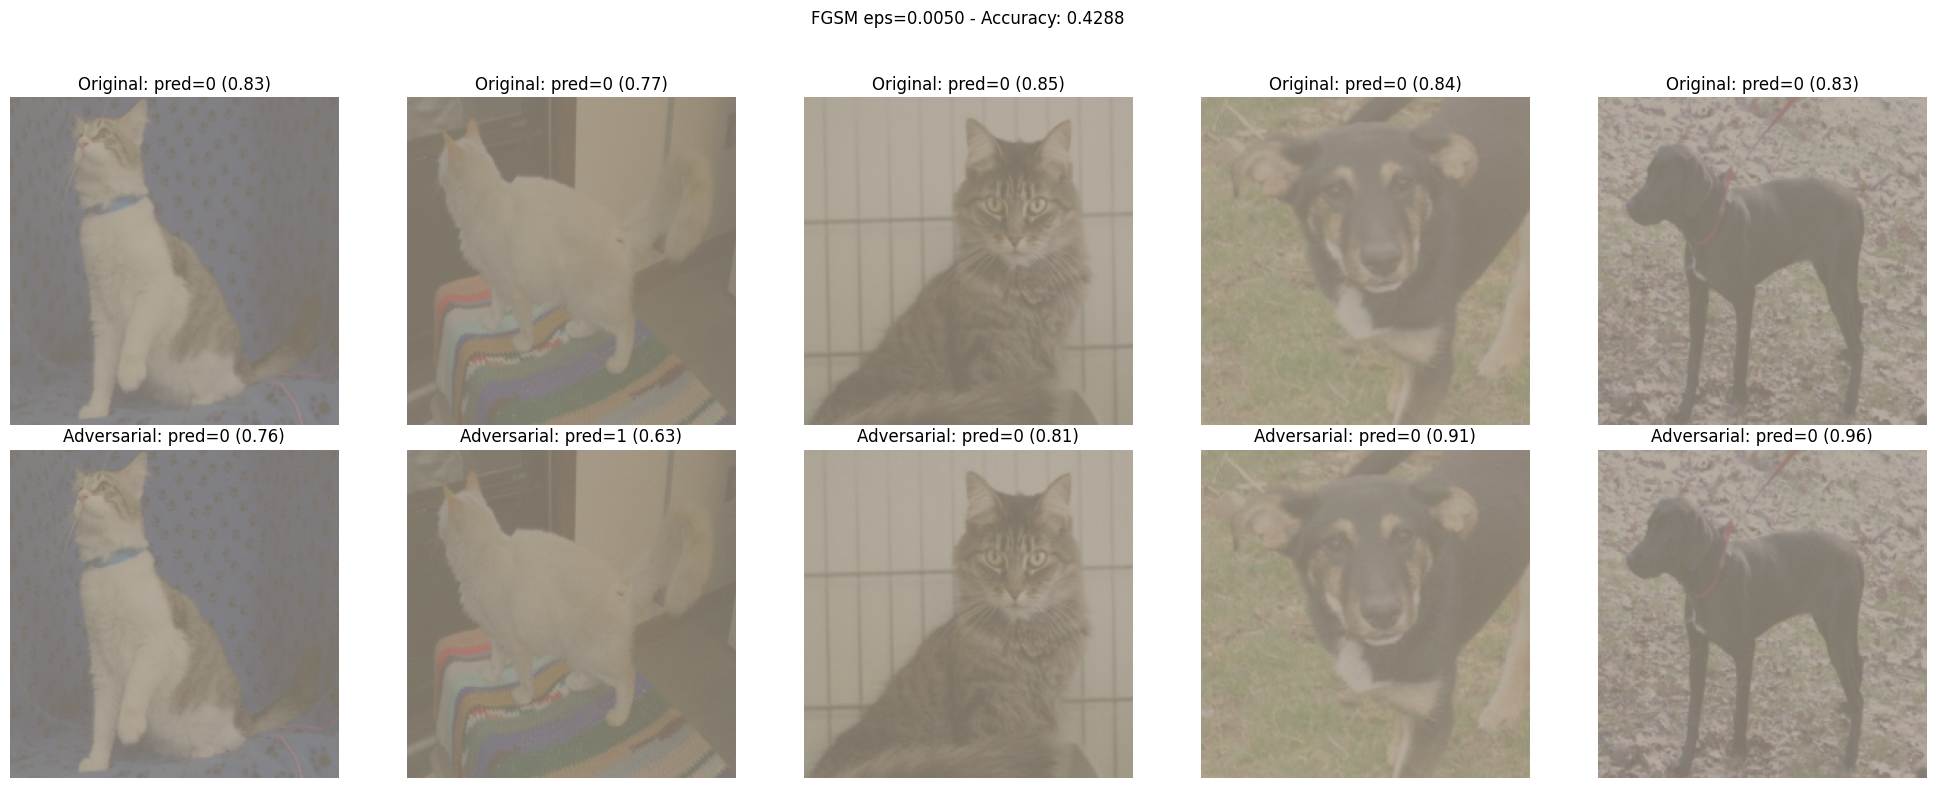

Epsilon=0.0100 -> Adversarial accuracy: 0.3412 (273/800)


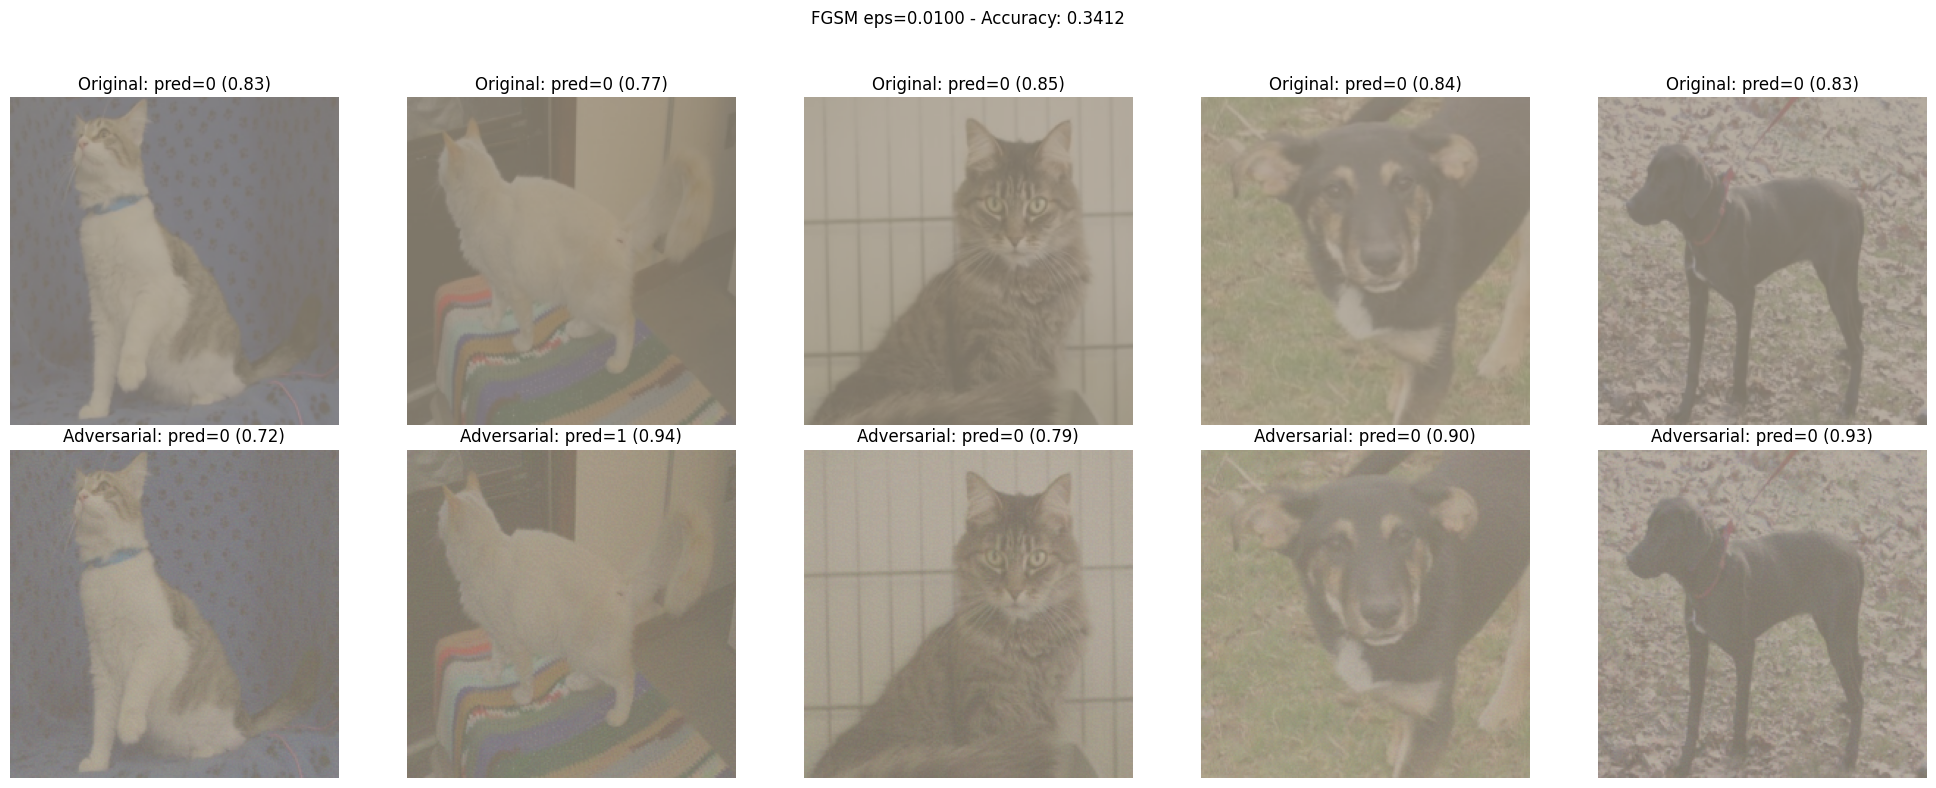

Epsilon=0.0300 -> Adversarial accuracy: 0.1800 (144/800)


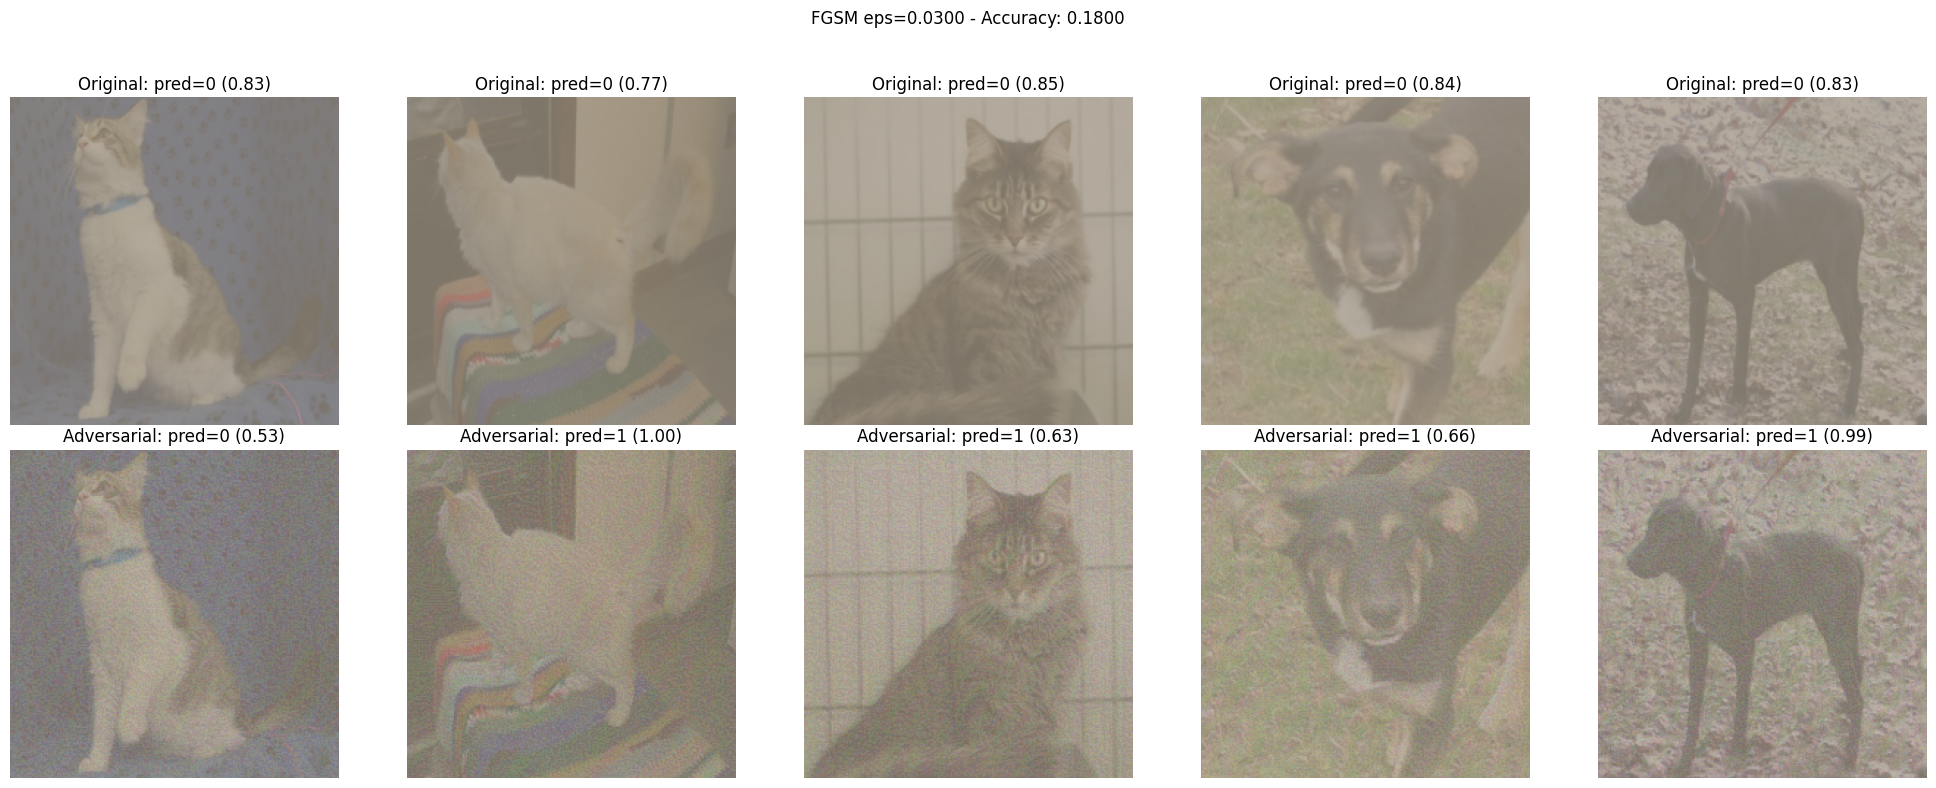


Summary:
Epsilon | Accuracy
--------------------
 0.0050 |   0.4288
 0.0100 |   0.3412
 0.0300 |   0.1800


In [8]:
results = []
for eps in epsilons:
    correct = 0
    total = 0
    adv_examples_to_show = []
    max_store = n_display

    for batch in loader:
        xb, yb = batch
        xb = xb.to(device)
        yb = yb.to(device)

        with torch.no_grad():
            logits = model(xb)
            probs = F.softmax(logits, dim=1)
            preds = logits.argmax(1)

        xb_adv, logits_adv = fgsm_normalized(model, xb, yb, epsilon=eps)
        probs_adv = F.softmax(logits_adv, dim=1)
        preds_adv = logits_adv.argmax(1)

        correct += (preds_adv == yb).sum().item()
        total += yb.numel()

        if len(adv_examples_to_show) < max_store:
            orig_imgs = batch_denorm_to_uint8(xb)
            adv_imgs  = batch_denorm_to_uint8(xb_adv)
            for i in range(min(xb.size(0), max_store - len(adv_examples_to_show))):
                adv_examples_to_show.append((
                    orig_imgs[i],
                    adv_imgs[i],
                    int(preds[i].item()),
                    int(preds_adv[i].item()),
                    float(probs[i, preds[i]].item()),
                    float(probs_adv[i, preds_adv[i]].item()),
                    int(yb[i].item()) if yb.numel() > i else None
                ))

        if not use_loader:
            break

    acc_adv = correct / max(1, total)
    results.append((eps, acc_adv))
    print(f"Epsilon={eps:.4f} -> Adversarial accuracy: {acc_adv:.4f} ({correct}/{total})")

    n_show = len(adv_examples_to_show)
    if n_show > 0:
        cols = min(n_show, n_display)
        plt.figure(figsize=(4*cols, 4*2))
        for i, (orig_img, adv_img, p_orig, p_adv, conf_orig, conf_adv, true_label) in enumerate(adv_examples_to_show[:cols]):
            ax = plt.subplot(2, cols, i+1)
            ax.imshow(orig_img)
            ax.axis('off')
            ax.set_title(f"Original: pred={p_orig} ({conf_orig:.2f})")
            ax2 = plt.subplot(2, cols, cols + i+1)
            ax2.imshow(adv_img)
            ax2.axis('off')
            ax2.set_title(f"Adversarial: pred={p_adv} ({conf_adv:.2f})")
        plt.suptitle(f"FGSM eps={eps:.4f} - Accuracy: {acc_adv:.4f}")
        plt.tight_layout(rect=[0,0,1,0.95])
        plt.show()

print("\nSummary:")
print("Epsilon | Accuracy")
print("-" * 20)
for eps, acc in results:
    print(f"{eps:7.4f} | {acc:8.4f}")


## Discussion

The results show that the SimpleCNN model's accuracy significantly decreases when evaluated on adversarial examples generated using the Fast Gradient Sign Method (FGSM). As the epsilon value increases, indicating a larger perturbation, the model's performance degrades further.